In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import gc

In [2]:
class FireModule(nn.Module):
    def __init__(self, in_channels, s1x1, e1x1, e3x3):
        super(FireModule, self).__init__()
        self.squeeze = nn.Conv2d(in_channels=in_channels, out_channels=s1x1, kernel_size=1, stride=1)
        self.expand1x1 = nn.Conv2d(in_channels=s1x1, out_channels=e1x1, kernel_size=1)
        self.expand3x3 = nn.Conv2d(in_channels=s1x1, out_channels=e3x3, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = F.relu(self.squeeze(x)) 
        x1 = self.expand1x1(x)   
        x2 = self.expand3x3(x)      
        x = F.relu(torch.cat((x1, x2), dim=1))  
        return x

In [3]:
class SqueezeNet(nn.Module):
    def __init__(self, out_channels):
        super(SqueezeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=2)
        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fire2 = FireModule(in_channels=96, s1x1=16, e1x1=64, e3x3=64)
        self.fire3 = FireModule(in_channels=128, s1x1=16, e1x1=64, e3x3=64)  
        self.fire4 = FireModule(in_channels=128, s1x1=32, e1x1=128, e3x3=128)
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fire5 = FireModule(in_channels=256, s1x1=32, e1x1=128, e3x3=128)
        self.fire6 = FireModule(in_channels=256, s1x1=48, e1x1=192, e3x3=192)
        self.fire7 = FireModule(in_channels=384, s1x1=48, e1x1=192, e3x3=192)
        self.fire8 = FireModule(in_channels=384, s1x1=64, e1x1=256, e3x3=256)
        self.max_pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fire9 = FireModule(in_channels=512, s1x1=64, e1x1=256, e3x3=256)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=out_channels, kernel_size=1, stride=1)
        self.avgpool = nn.AvgPool2d(kernel_size=12, stride=1)
        
    def forward(self, x):
        x = self.max_pool1(self.conv1(x))
        x = self.max_pool2(self.fire4(self.fire3(self.fire2(x))))
        x = self.max_pool3(self.fire8(self.fire7(self.fire6(self.fire5(x)))))
        x = self.avgpool(self.conv10(self.fire9(x)))
        return torch.flatten(x, start_dim=1)

In [4]:
import os
dataset_path = '../input/brain-mri-images-for-brain-tumor-detection'

paths = []
labels = []

for label in ['yes','no']:
    for dirname, _, filenames in os.walk(os.path.join(dataset_path,label)):
        for filename in filenames:
            paths.append(os.path.join(dirname, filename))
            labels.append(1 if label == 'yes' else 0)

len(paths), len(labels)

(253, 253)

In [5]:
sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()
    
print(max(sizes), min(sizes))

(1920, 1080) (150, 198)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(paths, labels, stratify=labels, test_size=0.2, shuffle=True, random_state=42)

print(len(X_train), len(X_test))

202 51


In [7]:
class MRIDataset():
    def __init__(self, paths, labels, augmentations=None):
        self.paths = paths
        self.labels = labels
        
        if augmentations is None:
            self.augmentations = transforms.Compose([transforms.ToTensor()])
        else:
            self.augmentations = augmentations
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        
        label = self.labels[index]
        
        sample = Image.open(self.paths[index]).convert(mode="RGB")
        sample = self.augmentations(sample)
            
        return (sample,torch.tensor(label, dtype=torch.float))

In [8]:
train_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

test_augmentations = transforms.Compose([transforms.Resize((224,224)),
                                          transforms.RandomHorizontalFlip(0.2),
                                          transforms.RandomVerticalFlip(0.1),
                                          transforms.RandomAutocontrast(0.2),
                                          transforms.RandomAdjustSharpness(0.3),
                                          transforms.ToTensor()
                                         ])

In [9]:
train_dataset = MRIDataset(X_train, y_train, augmentations=train_augmentations)
test_dataset = MRIDataset(X_test, y_test, augmentations=test_augmentations)

torch.Size([3, 224, 224])
0.0


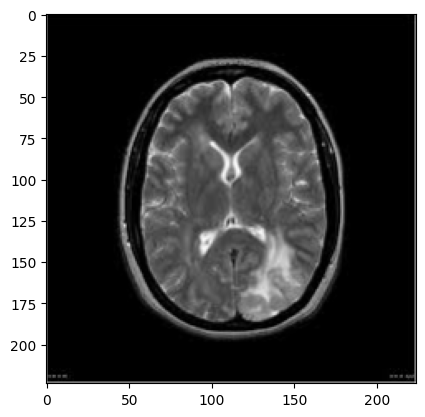

In [10]:
random_sample, random_label = test_dataset[0]
print(random_sample.shape)
plt.imshow(random_sample.permute(1,2,0))
print(random_label.item())

In [11]:
class Config:
    learning_rate = 1e-3
    epochs = 10
    train_batch_size = 8
    test_batch_size = 8

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size = Config.train_batch_size,
                                               shuffle = True,
                                               num_workers = 2
                                              )

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = Config.test_batch_size,
                                              shuffle = True,
                                              num_workers = 2
                                              )

len(train_dataloader), len(test_dataloader)

(26, 7)

In [13]:
squeezenet = SqueezeNet(1)
device = "cuda" if torch.cuda.is_available() else "cpu"
squeezenet = squeezenet.to(device)

In [14]:
class Trainer:
    
    def __init__(self, model, dataloaders, Config):
        self.model = model
        self.train, self.test = dataloaders
        
        self.Config = Config
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        self.loss_fn = nn.BCEWithLogitsLoss()
        
        
    def binary_accuracy(self, outputs, labels):
        return (torch.round(torch.sigmoid(outputs)) == labels).sum().item() / labels.shape[0]
        
        
    def train_one_epoch(self):
        
        running_loss = 0
        running_acc = 0
        
        for X,y in self.train:
            
            X = X.to(device, dtype = torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)
            
            self.optim.zero_grad()
            
            outputs = self.model(X)
            loss = self.loss_fn(outputs, y)
            
            loss.backward()
            self.optim.step()
            
            running_loss += loss.item()
            running_acc += self.binary_accuracy(outputs, y)
            
            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()
            
        train_loss = running_loss / len(self.train)
        train_acc = running_acc / len(self.train)
        
        return train_loss, train_acc
            
    
    def fit(self):
        
        losses = []
        accuracies = []
        
        for epoch in range(self.Config.epochs):
            
            self.model.train()
            
            train_loss, train_acc = self.train_one_epoch()
            losses.append(train_loss)
            accuracies.append(train_acc)
            
            print(f"EPOCH {epoch+1}/{self.Config.epochs}")
            print(f"Training Loss: {train_loss} | Training Accuracy: {train_acc}\n\n")
            
    
    @torch.no_grad()
    def inference(self):
        
        self.model.eval()
    
        running_acc = 0
        
        for X,y in self.test:
            
            X = X.to(device, torch.float)
            y = y.reshape(y.shape[0],1)
            y = y.to(device, dtype = torch.float)
            outputs = self.model(X)
            running_acc += self.binary_accuracy(outputs, y)
            
            del X
            del y
            gc.collect()
            torch.cuda.empty_cache()
            
        accuracy = running_acc / len(self.test)
        
        return accuracy

In [15]:
trainer = Trainer(squeezenet, (train_dataloader, test_dataloader), Config)
trainer.fit()

EPOCH 1/10
Training Loss: 0.6905743525578425 | Training Accuracy: 0.5865384615384616


EPOCH 2/10
Training Loss: 0.6751820124112643 | Training Accuracy: 0.6105769230769231


EPOCH 3/10
Training Loss: 0.6661555079313425 | Training Accuracy: 0.625


EPOCH 4/10
Training Loss: 0.6715991485577363 | Training Accuracy: 0.625


EPOCH 5/10
Training Loss: 0.6654972181870387 | Training Accuracy: 0.625


EPOCH 6/10
Training Loss: 0.6702326971750993 | Training Accuracy: 0.6105769230769231


EPOCH 7/10
Training Loss: 0.6697587714745448 | Training Accuracy: 0.6105769230769231


EPOCH 8/10
Training Loss: 0.6774076315072867 | Training Accuracy: 0.5961538461538461


EPOCH 9/10
Training Loss: 0.6700313549775344 | Training Accuracy: 0.6105769230769231


EPOCH 10/10
Training Loss: 0.6631224407599523 | Training Accuracy: 0.625




In [16]:
accuracy = trainer.inference()
accuracy*100

64.28571428571429